# Classifying emotions in movie dialogue using Watson NLP - pre-trained models

This notebook demonstrates how to classify emotions in tweets using Watson NLP python library

### What you'll learn in this notebook
Watson NLP offers so-called blocks for various NLP tasks. This notebook shows:

- **Syntax analysis** with the _Syntax block_ for English (`syntax_izumo_en_stock`). This block performs tokenization, lemmatization, parts of speech tagging, and dependency parsing on raw input documents so that custom models can properly classify documents.
- **Emotion classification** with the _Ensemble emotion workflow_ (`ensemble_classification-wf_en_emotion-stock`) and the _Aggregated emotion workflow_ (`aggregated_classification-wf_en_emotion-stock`). These model workflow classify text into five emotions: "sadness", "joy", "anger", "fear", "disgust".

## Table of Contents

1.  [Before you start](#beforeYouStart)
1.	[Data Loading](#loadData)
1.  [Data Processing](#dataProcessing)
    1. [Data formatting](#dataFormat)
    1. [Train test split](#trainTestSplit) 
1. [Running pretrained models](#pretrainedOOTB)
    1. [Ensemble emotion model](#ensemble)
    1. [Aggregated emotion workflow](#aggregated)
1. [Exploring document level token level predictions](#words)
1.  [Summary](#summary)

<a id="beforeYouStart"></a>
## 1. Before you start

<div class="alert alert-block alert-danger">
<b>Stop kernel of other notebooks.</b></div>

**Note:** If you have other notebooks currently running with the _Default Python 3.8 + Watson NLP XS_ environment, **stop their kernels** before running this notebook. All these notebooks share the same runtime environment, and if they are running in parallel, you may encounter memory issues. To stop the kernel of another notebook, open that notebook, and select _File > Stop Kernel_.

<div class="alert alert-block alert-warning">
<b>Set Project token.</b></div>

Before you can begin working on this notebook in Watson Studio in Cloud Pak for Data as a Service, you need to ensure that the project token is set so that you can access the project assets via the notebook.

When this notebook is added to the project, a project access token should be inserted at the top of the notebook in a code cell. If you do not see the cell above, add the token to the notebook by clicking **More > Insert project token** from the notebook action bar.  By running the inserted hidden code cell, a project object is created that you can use to access project resources.

![ws-project.mov](https://media.giphy.com/media/jSVxX2spqwWF9unYrs/giphy.gif)

<div class="alert alert-block alert-info">
<b>Tip:</b> Cell execution</div>

Note that you can step through the notebook execution cell by cell, by selecting Shift-Enter. Or you can execute the entire notebook by selecting **Cell -> Run All** from the menu.

<span style="color:blueviolet">Begin by importing and initializing some helper libs that are used throughout the notebook.</span>


In [1]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
import watson_nlp
import watson_nlp.data_model as dm

from sklearn.model_selection import train_test_split

from watson_core.toolkit import fileio
from watson_core.toolkit.quality_evaluation import QualityEvaluator, EvalTypes

from watson_nlp.blocks.classification.bert import BERT
from watson_nlp.blocks.classification.cnn import CNN
from watson_core.data_model.streams.resolver import DataStreamResolver
from watson_core.data_model.streams.resolver import DataStream
from watson_nlp.blocks.classification.svm import SVM
from watson_nlp.blocks.vectorization.tfidf import TFIDF

In [2]:
pd.set_option('display.max_colwidth', 0)

<span style="color:maroon">Printing either `block_models` or `workflow_models` will display a list of pretrained models available in the current version of Watson NLP</span>

In [3]:
block_models = watson_nlp.get_models().get_alias_models()
workflow_models = watson_nlp.get_workflows().get_alias_models()

<a id="loadData"></a>
## 2. Data Loading

The dataset contains over seven thousand quotations from tweets. The labeled emotions in the dataset are "anger", "sadness", "fear", "joy", and "disgust". Because some quotations have multiple sentences, they can be regarded as documents. The dataset is available internally at [Github Repo](https://github.ibm.com/hcbt/Watson-NLP/blob/main/Emotion-Classification/emotion_tweets.csv). The original source of this dataset is from [Kaggle](https://www.kaggle.com/datasets/anjaneyatripathi/emotion-classification-nlp?select=emotion-labels-train.csv) with a CC0: Public Domain license.
<br><br>
Any other emotion classification dataset may be used in substitution for the workflow outlined in this notebook.

Data format:
- .csv file that is loaded as a Pandas DataFrame with two columns, `text` and `label`

Data dictionary:
- text: string; text of tweets; this will be used as the input for models
- label: string; emotion class labels; this will be the what the model is trying to accurately predict

In [ ]:
# load data set into a dataframe
buffer = project.get_file("emotion-tweets.csv")
df = pd.read_csv(buffer)

<a id="dataProcessing"></a>
## 3. Data Processing

<a id="dataFormat"></a>
### 3.1. Data formatting

<span style="color:blue">Data prepared for Watson NLP models need to be formatted in such a way that there is a `text` feature column and a `labels` label column. The `labels` column needs have type `list`.</span>

In [5]:
def convertToList(x):
    return [x]

In [6]:
df['label'] = df['label'].apply(convertToList)
df = df.rename(columns={'label':'labels'})

<a id="trainTestSplit"></a>
### 3.2. Train Test Split

<div class="alert alert-block alert-info">
<b>Tip:</b> If you want to carry out emotion analysis on any other dataset, you should first upload the dataset into the project and then update the name of the file in the next cell</div>
<br>

<span style="color:blue">The data will be split into an 80/20 train-test split using sklearn and then exported into JSON format for the Watson NLP models to consume. Additionally, the column headers will be renamed to the expected `text` and `labels` names, with the labels having type list.</span>

In [7]:
df_train, df_test = train_test_split(df, test_size=0.2)

In [8]:
df_train.to_json('df_train.json', orient='records')
df_test.to_json('df_test.json', orient='records')

In [9]:
df_train

,text,labels
6084,HartRamsey'sUPLIFT If you're still discouraged it means you're listening to the wrong voices &amp; looking to the wrong source.Look to the LORD!,[sadness]
6830,@r0Ils ppl get triggered over u smiling they're irrelevant,[joy]
270,#smile is the #respect we give everyone.,[joy]
6945,@ArcticFantasy I would have almost took offense to this if I actually snapped you,[anger]
2576,"@ParrishWalton @kjmgolf Also, our best assets on offense are our RB's and our WR's (longterm). Have to have an offense to utilize both.",[anger]
...,...,...
5861,@Toucherandrich there was a US diver named steele johnson. i'd like him barred from the olympics.,[anger]
3315,Been working in Blanchardstown shopping centre for over 2 years now and I only figured out today where Marks &amp; Spencer's is #lost,[sadness]
6675,can it stay gloomy but get cold pls,[sadness]
569,Blake lively is flawless,[joy]


<a id="pretrainedOOTB"></a>
## 4. Running pretrained models
<span style="color:blue">Watson NLP has two pretrained/prebuilt emotion classificaiton models using the workflow system. 
The following examples will use *\"Such a sweet boy. But after much thought and careful consideration, I've decided that the ruler for the next ten thousand years is going to have to be... me.\"* as a single input test with the expected label to be *\"joy\"*.</span>

<a id="ensemble"></a>
### Ensemble emotion model
<br>
<span style="color:blue">Ensemble emotion model will perform document emotion classification. [Docs](https://pages.github.ibm.com/ai-foundation/watson-nlp-documentation/workflow_emotion_classification.html)</span>

In [10]:
# Load the Emotion workflow model for English
ensemble_emotion_model = watson_nlp.load(watson_nlp.download('ensemble_classification-wf_en_emotion-stock'))

<span style="color:blueviolet">The result of the Ensemble model returns a list of dictionaries that indicate each label and its confidence score. The highest confidence score deems the label of prediction.</span>

In [11]:
# Run the Emotion model on a single document
ensemble_emotion_result = ensemble_emotion_model.run("Such a sweet boy. But after much thought and careful consideration, I've decided that the ruler for the next ten thousand years is going to have to be... me. ")
print(ensemble_emotion_result)

{
  "classes": [
    {
      "class_name": "joy",
      "confidence": 0.520251523364674
    },
    {
      "class_name": "sadness",
      "confidence": 0.13437655658432934
    },
    {
      "class_name": "anger",
      "confidence": 0.030973352040305283
    },
    {
      "class_name": "fear",
      "confidence": 0.023922530189972323
    },
    {
      "class_name": "disgust",
      "confidence": 0.01345159203717203
    }
  ],
  "producer_id": {
    "name": "Voting based Ensemble",
    "version": "0.0.1"
  }
}


<span style="color:blueviolet">The Ensemble model also has the `model.evaluate_quality()` function, which allows the evaluation of an entire test set. The result returns a dictionary of dictionaries that map each label to its confusion matrix, precision and recall, and f1 score.</span>

In [12]:
test_data_file = "df_test.json"

quality_report = ensemble_emotion_model.evaluate_quality(test_data_file)
print(json.dumps(quality_report, indent=4))

{
    "per_class_confusion_matrix": {
        "joy": {
            "true_positive": 246,
            "true_negative": 0,
            "false_positive": 278,
            "false_negative": 78,
            "precision": 0.46946564885496184,
            "recall": 0.7592592592592593,
            "f1": 0.5801886792452831
        },
        "fear": {
            "true_positive": 129,
            "true_negative": 0,
            "false_positive": 43,
            "false_negative": 315,
            "precision": 0.75,
            "recall": 0.2905405405405405,
            "f1": 0.4188311688311688
        },
        "anger": {
            "true_positive": 130,
            "true_negative": 0,
            "false_positive": 82,
            "false_negative": 214,
            "precision": 0.6132075471698113,
            "recall": 0.37790697674418605,
            "f1": 0.4676258992805756
        },
        "sadness": {
            "true_positive": 164,
            "true_negative": 0,
            "false_posi

Based on the micro precision, recall, and f1 score, this Ensemble model did not perform well on our test data. However hyperparameter tuning of the pre-trained model may improve its performance.
<br><br>
*The micro metrics are taken here instead of the macro metrics because of the class imbalance in the data.

<span style="color:blue">By parsing out the results of the model runs, we can visualize the difference between predicted labels and actual labels.</span>

In [13]:
def run_emotion(text):
    emotion_result = ensemble_emotion_model.run(text)
    emo_dict = {emo.class_name:emo.confidence for emo in emotion_result.classes}
    return emo_dict

In [14]:
test_df = pd.read_json(test_data_file)
test_df['label'] = test_df['labels'].str[0]
test_df['label'] = test_df['label'].replace({'happiness':'joy'})

In [15]:
output = []
for line in test_df['text']:
    output.append([line, run_emotion(line)])

In [16]:
emotion_df = pd.DataFrame(output, columns=['text', 'emotions'])
emotion_df = pd.concat([emotion_df, emotion_df["emotions"].apply(pd.Series)], axis=1)
emotion_df = emotion_df.drop(['emotions'], axis=1)
emotion_df['highest_emotion'] = emotion_df[['joy', 'anger', 'sadness', 'fear', 'disgust']].idxmax(axis=1)

Text(0.5, 1.0, 'Test dataset labels')

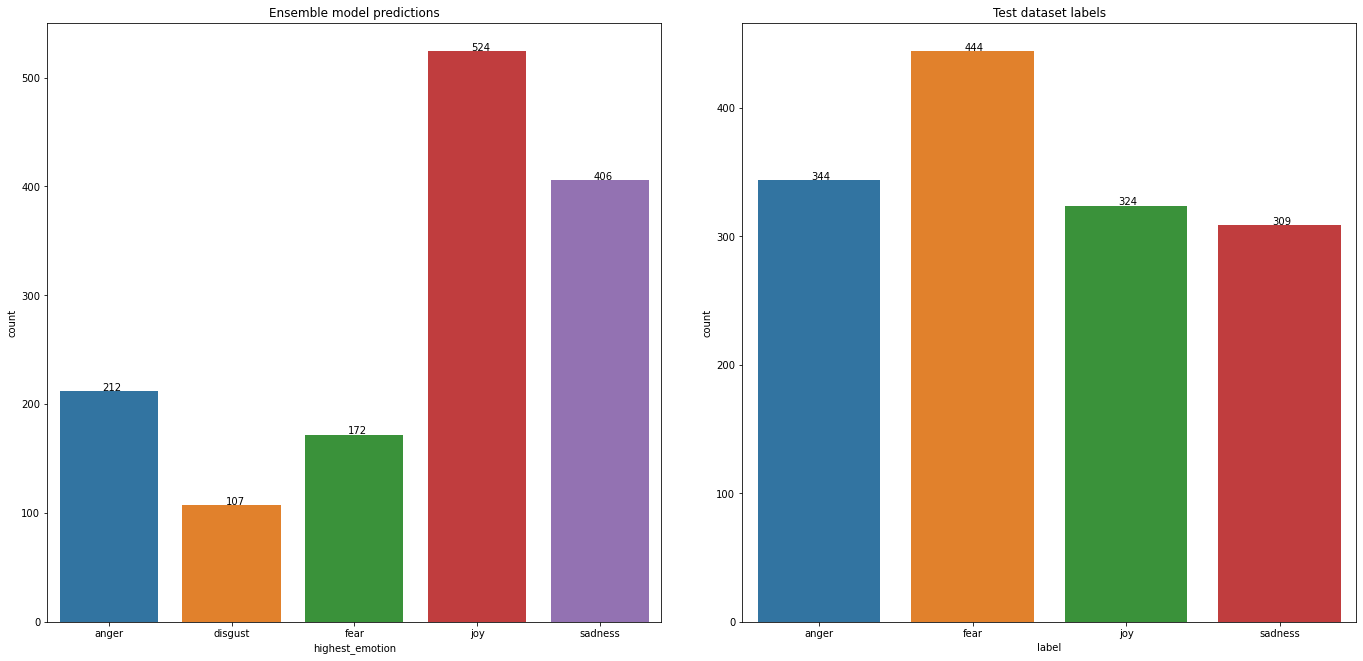

In [17]:
figure, ax = plt.subplots(ncols=2, figsize=(20,10))
figure.tight_layout(pad=5)
sns.countplot(x=emotion_df['highest_emotion'],  data=emotion_df['highest_emotion'], order=emotion_df['highest_emotion'].value_counts().sort_index().index, ax=ax[0])
for p, label in zip(ax[0].patches, emotion_df['highest_emotion'].value_counts().sort_index()): 
    ax[0].annotate(label, (p.get_x()+0.35, p.get_height()+0.5))
ax[0].set_title('Ensemble model predictions')

sns.countplot(x=test_df["label"],  data=test_df["label"], order=test_df["label"].value_counts().sort_index().index, ax=ax[1])
for p, label in zip(ax[1].patches, test_df["label"].value_counts().sort_index()):   
    ax[1].annotate(label, (p.get_x()+0.35, p.get_height()+0.5))
ax[1].set_title('Test dataset labels')

<a id="aggregated"></a>
### Aggregated emotion workflow
Aggregated emotion model has the capability of specifying target words in addition to document emotion classification. [Docs](https://pages.github.ibm.com/ai-foundation/watson-nlp-documentation/workflow_emotion_aggregated.html)

In [18]:
# Load the Emotion workflow model for English
aggregated_emotion_model = watson_nlp.load(watson_nlp.download('aggregated_classification-wf_en_emotion-stock'))

<span style="color:blue">By defining a target span of indices with the `target_mentions` parameter, the Aggregated model can predict emotion on exact segments of the input. </span>
<br><br>
<span style="color:blueviolet">Similarly to the Ensemble model, the Aggregated model returns a list of dictionaries that indicate each label and its confidence score. As before, the highest confidence score deems the label of prediction. 
The first dictionary in the result is the prediction of the overall input; the subsequent dictionaries with a \"target\" key is the prediction of each targeted text span.</span>

In [19]:
# span targets a section of the document given indices
target_mentions = dm.TargetMentionsPrediction([dm.TargetMentions([(7, 16)]), dm.TargetMentions([(28, 66)])])

aggregated_emotion_result_span = aggregated_emotion_model.run("Such a sweet boy. But after much thought and careful consideration, I've decided that the ruler for the next ten thousand years is going to have to be... me. ", 
                                   target_mentions=target_mentions)

print(aggregated_emotion_result_span)

{
  "emotion_predictions": [
    {
      "emotion": {
        "anger": 0.014531953677202513,
        "disgust": 0.015678834170103073,
        "fear": 0.004446345653956418,
        "joy": 0.9617643175703107,
        "sadness": 0.04595572027293119
      },
      "target": "sweet boy",
      "emotion_mentions": [
        {
          "span": {
            "begin": 0,
            "end": 17,
            "text": "Such a sweet boy."
          },
          "emotion": {
            "anger": 0.014531953677202513,
            "disgust": 0.015678834170103073,
            "fear": 0.004446345653956418,
            "joy": 0.9617643175703107,
            "sadness": 0.04595572027293119
          }
        }
      ]
    },
    {
      "emotion": {
        "anger": 0.16141723276990833,
        "disgust": 0.016278604327729256,
        "fear": 0.08282793606772569,
        "joy": 0.0715819208910971,
        "sadness": 0.2009543270775766
      },
      "target": "much thought and careful consideration",
     

<span style="color:blueviolet">By defining a target text phrase with the `target_phrases` parameter, the Aggregated model can predict emotion on exact words and phrases in the input. 
The result is just like the previous return, but this time with the \"target\" key having the targeted phrase.</span>

In [20]:
# text targets a section of the document given phrases
target_phrases = ['sweet boy', 'careful consideration']

aggregated_emotion_result_text = aggregated_emotion_model.run("Such a sweet boy. But after much thought and careful consideration, I've decided that the ruler for the next ten thousand years is going to have to be... me. ", 
                                   target_phrases=target_phrases)

print(aggregated_emotion_result_text)

{
  "emotion_predictions": [
    {
      "emotion": {
        "anger": 0.014531953677202513,
        "disgust": 0.015678834170103073,
        "fear": 0.004446345653956418,
        "joy": 0.9617643175703107,
        "sadness": 0.04595572027293119
      },
      "target": "sweet boy",
      "emotion_mentions": [
        {
          "span": {
            "begin": 0,
            "end": 17,
            "text": "Such a sweet boy."
          },
          "emotion": {
            "anger": 0.014531953677202513,
            "disgust": 0.015678834170103073,
            "fear": 0.004446345653956418,
            "joy": 0.9617643175703107,
            "sadness": 0.04595572027293119
          }
        }
      ]
    },
    {
      "emotion": {
        "anger": 0.16141723276990833,
        "disgust": 0.016278604327729256,
        "fear": 0.08282793606772569,
        "joy": 0.0715819208910971,
        "sadness": 0.2009543270775766
      },
      "target": "careful consideration",
      "emotion_mention

<span style="color:blue">By parsing out the results of the model runs, we can visualize the difference between predicted labels and actual labels.</span>

In [21]:
def run_emotion_2(text):
    # run the emotion model on the result of the syntax analysis
    emotion_result = aggregated_emotion_model.run(text, document_emotion=True)
    
    document_emotion = emotion_result.to_dict()['emotion_predictions'][0]['emotion']
    mention_emotion = [(sm['span']['text'], sm['emotion']) for sm in emotion_result.to_dict()['emotion_predictions'][0]['emotion_mentions']]
    return (document_emotion, mention_emotion)

# Helper method to create a new dataframe with the corresponding emotion
def create_emotion_dataframe(df):
    emotion = df['text'].apply(lambda text: run_emotion_2(text))
    emotion_df = pd.DataFrame.from_records(emotion, columns=('Document emotion', 'Mention emotion'))
    return emotion_df

In [22]:
# this will take some time
emotion_2_df = create_emotion_dataframe(test_df)

In [23]:
document_emotion_df = df[['text']].merge(pd.DataFrame(emotion_2_df['Document emotion'].values.tolist()), 
                                          how='left', 
                                          left_index=True, 
                                          right_index=True)
document_emotion_df['highest_emotion'] = document_emotion_df[['joy', 'anger', 'sadness', 'fear', 'disgust']].idxmax(axis=1)

Text(0.5, 1.0, 'Test dataset labels')

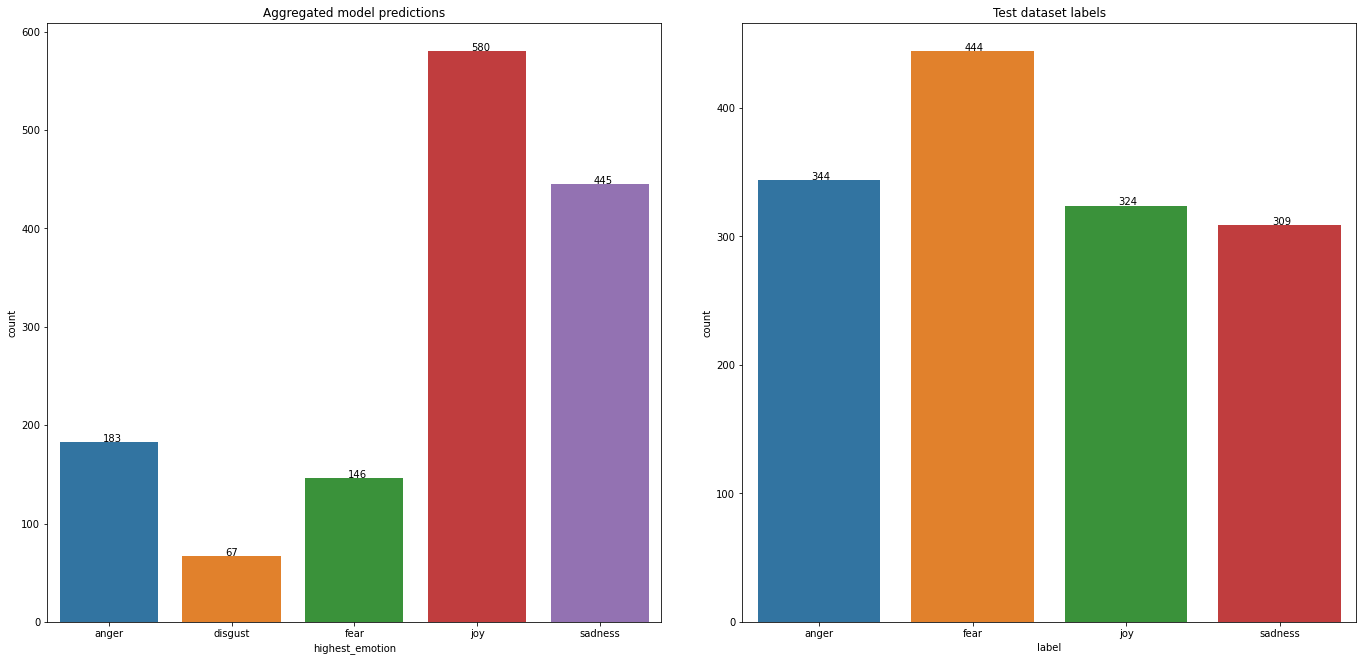

In [24]:
figure, ax = plt.subplots(ncols=2, figsize=(20,10))
figure.tight_layout(pad=5)
sns.countplot(x=document_emotion_df["highest_emotion"],  data=document_emotion_df['highest_emotion'], order=document_emotion_df["highest_emotion"].value_counts().sort_index().index, ax=ax[0])
for p, label in zip(ax[0].patches, document_emotion_df["highest_emotion"].value_counts().sort_index()):   
    ax[0].annotate(label, (p.get_x()+0.35, p.get_height()+0.5))
ax[0].set_title('Aggregated model predictions')

sns.countplot(x=test_df["label"],  data=test_df["label"], order=test_df["label"].value_counts().sort_index().index, ax=ax[1])
for p, label in zip(ax[1].patches, test_df["label"].value_counts().sort_index()):   
    ax[1].annotate(label, (p.get_x()+0.35, p.get_height()+0.5))
ax[1].set_title('Test dataset labels')

<a id="words"></a>
## 5. Exploring document level token level predictions
<span style="color:blue">The cells that follow are an exploration of the Aggregated model with regard to document level and token level predictions. The model returns will be constructed into dataframes to better view results.</span>

In [25]:
# set the emotion model as the aggregated out of the box model because of its target mention capability
emotion_model = aggregated_emotion_model

In [26]:
def extract_emotion(text):
    # run the emotion model on the result of the syntax analysis
    emotion_result = emotion_model.run(text, document_emotion=True)
    
    document_emotion = emotion_result.to_dict()['emotion_predictions'][0]['emotion']
    mention_emotion = [(sm['span']['text'], sm['emotion']) for sm in emotion_result.to_dict()['emotion_predictions'][0]['emotion_mentions']]
    return (document_emotion, mention_emotion)

# Helper method to create a new dataframe with the corresponding emotion
def create_emotion_dataframe(df):
    emotion = df['text'].apply(lambda text: extract_emotion(text))
    emotion_df = pd.DataFrame.from_records(emotion, columns=('Document emotion', 'Mention emotion'))
    return emotion_df

In [27]:
# this will take some time
emotion_df = create_emotion_dataframe(df)

<span style="color:blue">In the context of the dataset, each row is a different and unrelated movie dialog from the entire dataset (before train-test split).</span>

In [28]:
document_emotion_df = df[['text']].merge(pd.DataFrame(emotion_df['Document emotion'].values.tolist()), 
                                          how='left', 
                                          left_index=True, 
                                          right_index=True)
document_emotion_df

,text,anger,disgust,fear,joy,sadness
0,Just got back from seeing @GaryDelaney in Burslem. AMAZING!! Face still hurts from laughing so much #hilarious,0.056858,0.044138,0.045549,0.550413,0.202194
1,Oh dear an evening of absolute hilarity I don't think I have laughed so much in a long time! 😂,0.054336,0.050418,0.060113,0.517021,0.282575
2,Been waiting all week for this game ❤️❤️❤️ #cheer #friday ❤️,0.012933,0.035092,0.043118,0.577688,0.233589
3,"@gardiner_love : Thank you so much, Gloria! You're so sweet, and thoughtful! You just made my day more joyful! I love you too! 😊💕",0.016570,0.007498,0.023562,0.921948,0.035045
4,"I feel so blessed to work with the family that I nanny for ❤️ nothing but love &amp; appreciation, makes me smile.",0.004601,0.002299,0.011745,0.995290,0.009963
...,...,...,...,...,...,...
7097,Common app just randomly logged me out as I was writing the last part of my college essay and lost all of it 😭😭😭,0.051804,0.007056,0.079894,0.012903,0.911346
7098,"I'd rather laugh with the rarest genius, in beautiful alliance with his own being, where he kept his sadness. #melancholy",0.027158,0.019089,0.052172,0.592549,0.528014
7099,If you #invest in my new #film I will stop asking you to invest in my new film. #concessions #crime #despair #shortsightedness #celebrities,0.217156,0.049365,0.231188,0.335586,0.123174
7100,"Just watched Django Unchained, Other people may frown, but I titter in delight! 2/5",0.069020,0.041617,0.093447,0.523988,0.203912


<span style="color:blueviolet">Each document (dialog) is broken down into tokenized \"sentences\" called `Mention`. The dataframe displays confidence scores for each Mention in the dialog.</span>

In [29]:
mention_emotion_df = df[['text']].merge(emotion_df['Mention emotion'], 
                                        how='left', 
                                        left_index=True, 
                                        right_index=True).explode('Mention emotion')
mention_emotion_df[['Mention', 'Mention emotion']] = pd.DataFrame(mention_emotion_df['Mention emotion'].values.tolist(), 
                                                                  index=mention_emotion_df.index)
mention_emotion_df = mention_emotion_df.reset_index(drop=True)
mention_emotion_df = mention_emotion_df.merge(pd.DataFrame(mention_emotion_df['Mention emotion'].values.tolist()), 
                                              how='left', 
                                              left_index=True, 
                                              right_index=True).drop(['Mention emotion'], 
                                                                     axis=1).reset_index(drop=True)
mention_emotion_df

,text,Mention,anger,disgust,fear,joy,sadness
0,Just got back from seeing @GaryDelaney in Burslem. AMAZING!! Face still hurts from laughing so much #hilarious,Just got back from seeing @GaryDelaney in Burslem.,0.063471,0.114040,0.038112,0.536179,0.456526
1,Just got back from seeing @GaryDelaney in Burslem. AMAZING!! Face still hurts from laughing so much #hilarious,AMAZING!!,0.006673,0.002759,0.002942,0.996689,0.011980
2,Just got back from seeing @GaryDelaney in Burslem. AMAZING!! Face still hurts from laughing so much #hilarious,Face still hurts from laughing so much #hilarious,0.100429,0.015616,0.095594,0.118371,0.138076
3,Oh dear an evening of absolute hilarity I don't think I have laughed so much in a long time! 😂,Oh dear an evening of absolute hilarity I don't think I have laughed so much in a long time!,0.059420,0.029924,0.034078,0.683562,0.306138
4,Oh dear an evening of absolute hilarity I don't think I have laughed so much in a long time! 😂,😂,0.049252,0.070912,0.086147,0.350479,0.259012
...,...,...,...,...,...,...,...
11933,If you #invest in my new #film I will stop asking you to invest in my new film. #concessions #crime #despair #shortsightedness #celebrities,If you #invest in my new #film I will stop asking you to invest in my new film.,0.263648,0.043922,0.067936,0.611174,0.087077
11934,If you #invest in my new #film I will stop asking you to invest in my new film. #concessions #crime #despair #shortsightedness #celebrities,#concessions #crime #despair #shortsightedness #celebrities,0.170665,0.054808,0.394440,0.059998,0.159270
11935,"Just watched Django Unchained, Other people may frown, but I titter in delight! 2/5","Just watched Django Unchained, Other people may frown, but I titter in delight!",0.071630,0.040866,0.024483,0.777526,0.093660
11936,"Just watched Django Unchained, Other people may frown, but I titter in delight! 2/5",2/5,0.066409,0.042368,0.162411,0.270450,0.314163


## 6. Summary

<span style="color:blue">This notebook shows you how to use the Watson NLP library and how quickly and easily you can get started with Watson NLP by running the pretrained models for emotion analysis.

Please note that this content is made available by IBM Build Lab to foster Embedded AI technology adoption. The content may include systems & methods pending patent with USPTO and protected under US Patent Laws. For redistribution of this content, IBM will use release process. For any questions please log an issue in the hosting [GitHub](https://github.com/ibm-build-labs/Watson-NLP) repository. 

Developed by IBM Build Lab 

Copyright - 2022 IBM Corporation 